# Amazon Best seller prediction

### Loading the Amazon Data from Kaggle @ https://www.kaggle.com/datasets/asaniczka/usa-optimal-product-price-prediction/

In [220]:
#Loading all the required libraries
import os
import calendar
from pathlib import Path # to interact with file system.
import numpy as np # for working with arrays.
import networkx as nx
import pandas as pd # for working with data frames (tables).
from pandas.plotting import scatter_matrix, parallel_coordinates
import seaborn as sns # Making statistical graphs on top of what matplot can do 
from sklearn import preprocessing
import matplotlib.pylab as plt # %matplotlib inline renders the figure in a notebook

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#from mord import LogisticIT #If you're looking for ordinal multi-class (more than 2 levels)

from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
from scipy import stats
import math
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from pandas.plotting import parallel_coordinates
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

%matplotlib inline


### Loading the data to amz_df dataframe

In [221]:
amz_df = pd.read_csv('amazon_price.csv')
amz_df.head()

,uid,asin,title,stars,reviews,price,category,isBestSeller,boughtInLastMonth
0,1,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",4.5,0,139.99,Suitcases,False,2000
1,2,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,4.5,0,169.99,Suitcases,False,1000
2,3,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,4.6,0,365.49,Suitcases,False,300
3,4,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,4.6,0,291.59,Suitcases,False,400
4,5,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,4.5,0,174.99,Suitcases,False,400


In [222]:
amz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735414 entries, 0 to 1735413
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   category           object 
 7   isBestSeller       bool   
 8   boughtInLastMonth  int64  
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 107.6+ MB


In [223]:
amz_df.shape

(1735414, 9)

###  Dropping uid,asin as they don't have any significance in analysis

In [224]:
amazon_df=amz_df.drop(['uid','asin','title'],axis=1)
amazon_df.head()

,stars,reviews,price,category,isBestSeller,boughtInLastMonth
0,4.5,0,139.99,Suitcases,False,2000
1,4.5,0,169.99,Suitcases,False,1000
2,4.6,0,365.49,Suitcases,False,300
3,4.6,0,291.59,Suitcases,False,400
4,4.5,0,174.99,Suitcases,False,400


### Number of categories and their types

In [225]:
cat_number = amazon_df['category'].nunique()
cat_number

236

In [226]:
cat_all = amazon_df['category'].unique()
cat_all

array(['Suitcases', "Men's Clothing", 'Consoles & Accessories',
       "Men's Shoes", "Men's Accessories", 'Vacuum Cleaners & Floor Care',
       'Televisions & Video Products', 'Additive Manufacturing Products',
       'Headphones & Earbuds', "Boys' Watches", "Girls' Clothing",
       "Boys' Clothing", 'Pregnancy & Maternity Products',
       'Shaving & Hair Removal Products', 'Fabric Decorating',
       'Industrial Materials', 'Smart Home: Security Cameras and Systems',
       'Office Electronics', 'Sports & Outdoor Play Toys',
       "Kids' Play Tractors", 'Slot Cars, Race Tracks & Accessories',
       'Video Games', 'Smart Home: Voice Assistants and Hubs',
       'Light Bulbs', 'Toys & Games', "Kids' Furniture",
       'Automotive Tires & Wheels', 'Wellness & Relaxation Products',
       'Automotive Tools & Equipment', 'Baby & Toddler Toys',
       "Kids' Play Boats", 'Computer Monitors', "Girls' Jewelry",
       'Luggage', 'Printmaking Supplies', "Women's Handbags",
       'Foot, 

In [227]:
cat_split = amazon_df['category'].value_counts()
cat_split = cat_split.sort_values(ascending=False)
cat_split_top= cat_split.head()
cat_split_least =  cat_split.tail()

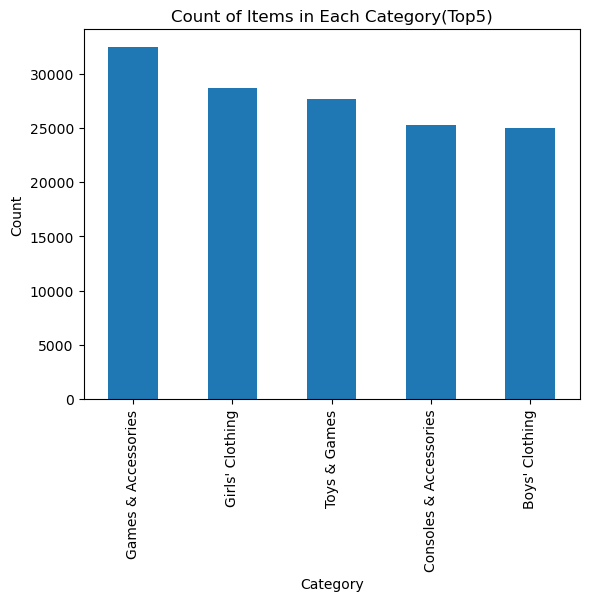

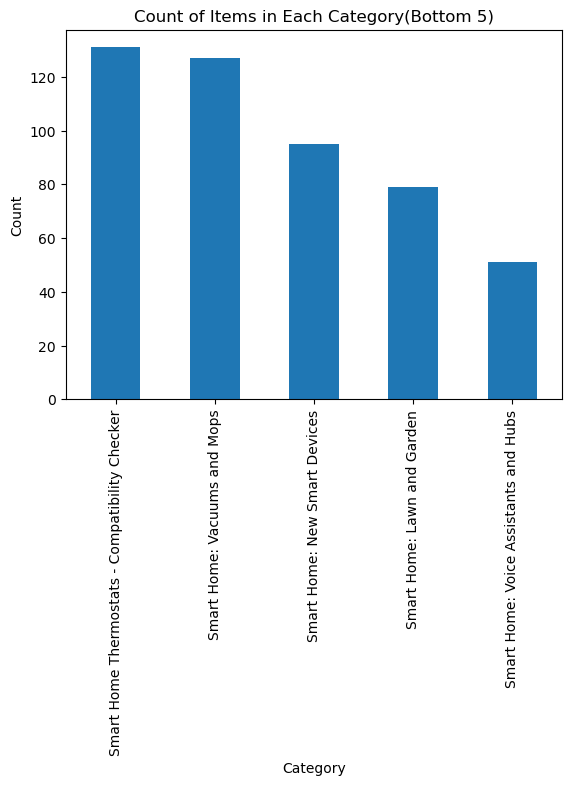

In [228]:
# Plot the count of items in each category
cat_split_top.plot(kind='bar')
plt.title('Count of Items in Each Category(Top5)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

cat_split_least.plot(kind='bar')
plt.title('Count of Items in Each Category(Bottom 5)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()




In [145]:
#Basic Stat summary
amazon_df.describe()

,stars,reviews,price,boughtInLastMonth
count,1.735414e+06,1.735414e+06,1.735414e+06,1.735414e+06
mean,4.054889e+00,1.772809e+02,4.220253e+01,1.907960e+02
std,1.278032e+00,1.774467e+03,1.249822e+02,9.952445e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.200000e+00,0.000000e+00,1.199000e+01,0.000000e+00
50%,4.500000e+00,0.000000e+00,1.989000e+01,0.000000e+00
75%,4.700000e+00,0.000000e+00,3.500000e+01,1.000000e+02
max,5.000000e+00,3.465630e+05,1.973181e+04,1.000000e+05


In [146]:
amazon_df.isnull().sum()

stars                0
reviews              0
price                0
category             0
isBestSeller         0
boughtInLastMonth    0
dtype: int64

## There are few products which has price error and marked as 0, these records were identified and removed as these were outliers

In [229]:
zero_price_records = amazon_df[amazon_df['price'] == 0]
zero_price_records

,stars,reviews,price,category,isBestSeller,boughtInLastMonth
177,3.8,0,0.0,Suitcases,False,0
180,4.5,0,0.0,Suitcases,False,0
252,0.0,0,0.0,Suitcases,False,0
328,3.9,0,0.0,Suitcases,False,0
445,4.0,0,0.0,Suitcases,False,0
...,...,...,...,...,...,...
1734512,2.9,0,0.0,Boys' Shoes,False,0
1734518,4.4,0,0.0,Boys' Shoes,False,0
1735258,4.4,0,0.0,Men's Accessories,False,0
1735336,4.2,0,0.0,Men's Accessories,False,0


In [230]:
amazon_df = amazon_df[amazon_df['price'] != 0]
amazon_df.head()

,stars,reviews,price,category,isBestSeller,boughtInLastMonth
0,4.5,0,139.99,Suitcases,False,2000
1,4.5,0,169.99,Suitcases,False,1000
2,4.6,0,365.49,Suitcases,False,300
3,4.6,0,291.59,Suitcases,False,400
4,4.5,0,174.99,Suitcases,False,400


In [149]:
amazon_df.describe()

,stars,reviews,price,boughtInLastMonth
count,1.697656e+06,1.697656e+06,1.697656e+06,1.697656e+06
mean,4.060162e+00,1.763611e+02,4.314117e+01,1.929835e+02
std,1.270932e+00,1.760208e+03,1.262041e+02,1.001742e+03
min,0.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00
25%,4.200000e+00,0.000000e+00,1.199000e+01,0.000000e+00
50%,4.500000e+00,0.000000e+00,1.999000e+01,0.000000e+00
75%,4.700000e+00,0.000000e+00,3.599000e+01,1.000000e+02
max,5.000000e+00,3.465630e+05,1.973181e+04,1.000000e+05


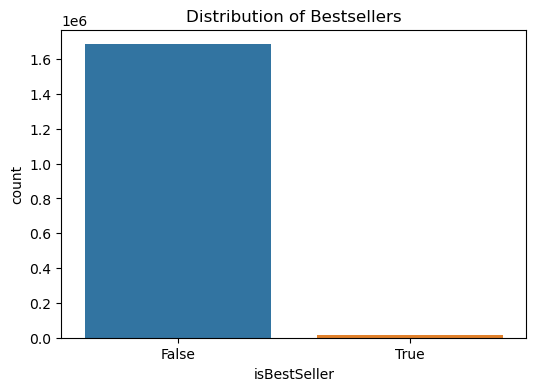

False    1684381
True       13275
Name: isBestSeller, dtype: int64

In [127]:
plt.figure(figsize=(6, 4))
sns.countplot(x='isBestSeller', data=amazon_df)
plt.title('Distribution of Bestsellers')

plt.show()
bestseller_counts = amazon_df['isBestSeller'].value_counts()
bestseller_counts


In [150]:
category_proportions = amazon_df.groupby('category')['isBestSeller'].mean()
print(category_proportions)


category
Abrasive & Finishing Products      0.003581
Accessories & Supplies             0.015824
Additive Manufacturing Products    0.000923
Arts & Crafts Supplies             0.002377
Arts Crafts & Sewing Storage       0.001247
                                     ...   
Women's Handbags                   0.000746
Women's Jewelry                    0.003571
Women's Shoes                      0.002899
Women's Watches                    0.000678
eBook Readers & Accessories        0.001859
Name: isBestSeller, Length: 236, dtype: float64


In [151]:
num_corr= amazon_df[['stars', 'reviews', 'price', 'boughtInLastMonth']].corr()
num_corr

,stars,reviews,price,boughtInLastMonth
stars,1.000000,0.033749,-0.080592,0.068094
reviews,0.033749,1.000000,-0.009699,0.133618
price,-0.080592,-0.009699,1.000000,-0.030939
boughtInLastMonth,0.068094,0.133618,-0.030939,1.000000


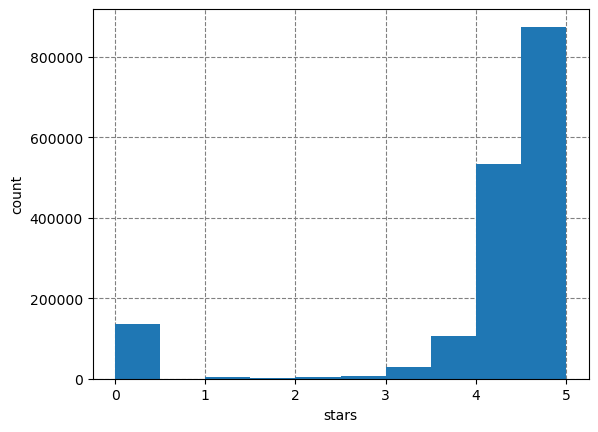

In [152]:
fig, ax = plt.subplots()
ax.hist(amazon_df.stars)
ax.set_axisbelow(True)  # Show the grid lines behind the histogram
ax.grid(which='major', color='grey', linestyle='--')
ax.set_xlabel('stars')
ax.set_ylabel('count')
plt.show()

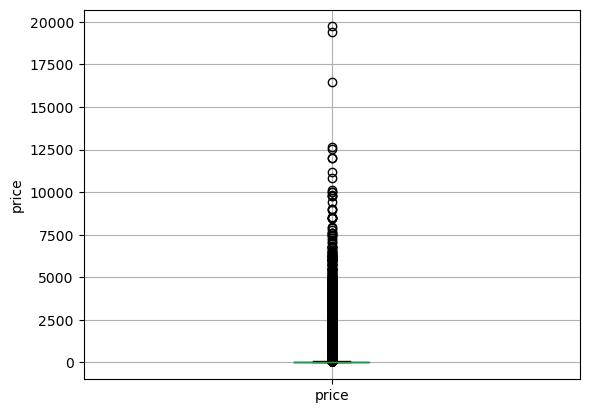

In [153]:
ax = amazon_df.boxplot(column='price')
ax.set_ylabel('price')
plt.show()

In [231]:
amazon_df = amazon_df[amazon_df['price'] <= 15000]

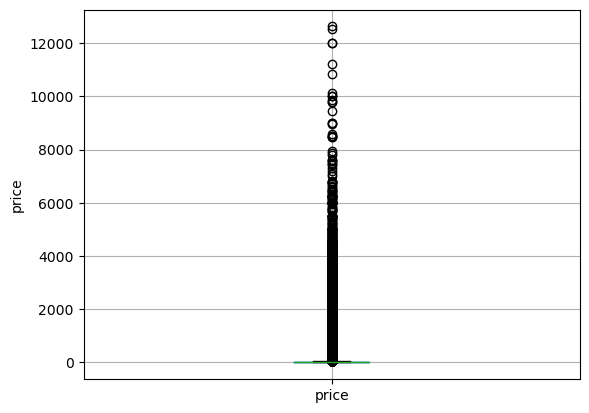

In [100]:
ax = amazon_df.boxplot(column='price')
ax.set_ylabel('price')
plt.show()

In [132]:
amazon_df.columns

Index(['stars', 'reviews', 'price', 'category', 'isBestSeller',
       'boughtInLastMonth'],
      dtype='object')

In [233]:
amazon_logit = amazon_df
amazon_logit.head()

,stars,reviews,price,category,isBestSeller,boughtInLastMonth
0,4.5,0,139.99,Suitcases,False,2000
1,4.5,0,169.99,Suitcases,False,1000
2,4.6,0,365.49,Suitcases,False,300
3,4.6,0,291.59,Suitcases,False,400
4,4.5,0,174.99,Suitcases,False,400


In [187]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'X' is your DataFrame and 'category' is the column you label encoded
label_encoder = LabelEncoder()
amazon_logit['category_encoded'] = label_encoder.fit_transform(amazon_logit['category'])


# Display the mapping between categories and encoded values
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Category Mapping:")
print(category_mapping)


Category Mapping:
{'Abrasive & Finishing Products': 0, 'Accessories & Supplies': 1, 'Additive Manufacturing Products': 2, 'Arts & Crafts Supplies': 3, 'Arts Crafts & Sewing Storage': 4, 'Automotive Enthusiast Merchandise': 5, 'Automotive Exterior Accessories': 6, 'Automotive Interior Accessories': 7, 'Automotive Paint & Paint Supplies': 8, 'Automotive Performance Parts & Accessories': 9, 'Automotive Replacement Parts': 10, 'Automotive Tires & Wheels': 11, 'Automotive Tools & Equipment': 12, 'Baby': 13, 'Baby & Child Care Products': 14, 'Baby & Toddler Feeding Supplies': 15, 'Baby & Toddler Toys': 16, 'Baby Activity & Entertainment Products': 17, "Baby Boys' Clothing & Shoes": 18, 'Baby Care Products': 19, 'Baby Diapering Products': 20, 'Baby Gifts': 21, "Baby Girls' Clothing & Shoes": 22, 'Baby Safety Products': 23, 'Baby Stationery': 24, 'Baby Strollers & Accessories': 25, 'Baby Travel Gear': 26, 'Backpacks': 27, 'Bath Products': 28, 'Beading & Jewelry Making': 29, 'Beauty & Personal 

In [192]:
amazon_logit['isBestSeller_en'] = label_encoder.fit_transform(amazon_logit['isBestSeller'])
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Category Mapping:")
print(category_mapping)

Category Mapping:
{False: 0, True: 1}


In [194]:
amazon_logit.head()

,stars,reviews,price,category,isBestSeller,boughtInLastMonth,category_encoded,isBestSeller_en
0,4.5,0,139.99,Suitcases,False,2000,204,0
1,4.5,0,169.99,Suitcases,False,1000,204,0
2,4.6,0,365.49,Suitcases,False,300,204,0
3,4.6,0,291.59,Suitcases,False,400,204,0
4,4.5,0,174.99,Suitcases,False,400,204,0


In [195]:
amazon_logit = amazon_logit.drop('category', axis=1)
amazon_logit = amazon_logit.drop('isBestSeller', axis=1)
amazon_logit.head()

,stars,reviews,price,boughtInLastMonth,category_encoded,isBestSeller_en
0,4.5,0,139.99,2000,204,0
1,4.5,0,169.99,1000,204,0
2,4.6,0,365.49,300,204,0
3,4.6,0,291.59,400,204,0
4,4.5,0,174.99,400,204,0


In [196]:
amazon_logit.columns

Index(['stars', 'reviews', 'price', 'boughtInLastMonth', 'category_encoded',
       'isBestSeller_en'],
      dtype='object')

In [197]:
predictors = ['stars', 'reviews', 'price','boughtInLastMonth' ,
       'category_encoded']
outcome= 'isBestSeller_en'

In [112]:
# Assuming 'df' is your DataFrame and 'column_to_convert' is the column you want to convert to boolean



,stars,reviews,price,isBestSeller,boughtInLastMonth,category_encoded
0,4.5,0,139.99,False,2000,204
1,4.5,0,169.99,False,1000,204
2,4.6,0,365.49,False,300,204
3,4.6,0,291.59,False,400,204
4,4.5,0,174.99,False,400,204


In [198]:
X = amazon_logit[predictors]
y = amazon_logit[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=3)
print(X)
print(y)

         stars  reviews   price  boughtInLastMonth  category_encoded
0          4.5        0  139.99               2000               204
1          4.5        0  169.99               1000               204
2          4.6        0  365.49                300               204
3          4.6        0  291.59                400               204
4          4.5        0  174.99                400               204
...        ...      ...     ...                ...               ...
1735409    4.4        0   33.99                  0               136
1735410    3.6        0    8.54                  0               136
1735411    4.5        0   54.36                  0               136
1735412    4.9        0   18.79                  0               136
1735413    0.0        0   14.99                  0               136

[1697656 rows x 5 columns]
0          0
1          0
2          0
3          0
4          0
          ..
1735409    0
1735410    0
1735411    0
1735412    0
1735413    0
N

In [200]:

logit_reg = sm.GLM(y, X, family=sm.families.Binomial())

In [201]:
logit_reg.fit().summary()

C:\Users\meeta\Downloads\Anaconda\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\meeta\Downloads\Anaconda\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
C:\Users\meeta\Downloads\Anaconda\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        isBestSeller_en   No. Observations:              1697656
Model:                            GLM   Df Residuals:                  1697651
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 12 Dec 2023   Deviance:                   1.9787e+05
Time:                        22:53:14   Pearson chi2:                 4.06e+16
No. Iterations:                    11   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
stars                -0.6146      0.003   -222.716      0.000      -0.620      -0.609
reviews            5.609e-05   1.73e-06     32.371      0.000    5.27e-05    5.95e-05
price                -0.0549      0.001   -104.543      0.000      -0.056      -0.054
boughtInLastMonth     0.0003   3.66e-06     89.557      0.000       0.000       0.000
category_encoded     -0.0135      0.000   -119.799      0.000      -0.014      -0.013
=====================================================================================
"""

In [202]:
math.exp(-0.6146)

0.5408571949244794

In [203]:
import numpy as np
import math

def AIC_score(y_true, y_pred, df):
    n = len(y_true)
    resid = y_true - y_pred
    
    # Ensure there are no zero residuals
    if any(resid == 0):
        return float('inf')  # Return infinity for AIC if there are zero residuals
    
    sse = np.sum(resid ** 2)
    constant = n + n * np.log(2 * np.pi)
    
    try:
        return n * math.log(sse / n) + constant + 2 * df
    except ValueError as e:
        print(f"Error in AIC calculation: {e}")
        return float('inf')  # Return infinity for AIC if there are issues with the calculation

# Rest of your code...


In [205]:
train_X,valid_X,train_y,valid_y=train_test_split(X,y,test_size=0.4,random_state=1)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

#Get intercepts, coefficients, and AIC
print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print() #Creates a Line space
df = len(train_X.columns) + 1
print('AIC:', AIC_score(valid_y, logit_reg.predict(valid_X), df))

intercept  -7.787621950621615
          stars   reviews     price  boughtInLastMonth  category_encoded
coeff  0.607383  0.000053 -0.002101            0.00031          0.001594

AIC: inf


In [206]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

# display four different cases
interestingCases = [221, 932, 276, 703]
logit_result_reset = logit_result.reset_index(drop=True)
print(logit_result_reset.loc[interestingCases])

     actual      p(0)      p(1)  predicted
221       0  0.993570  0.006430          0
932       0  0.992683  0.007317          0
276       0  0.988302  0.011698          0
703       0  0.991732  0.008268          0


In [207]:
classificationSummary(valid_y,logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9920)

       Prediction
Actual      0      1
     0 673505    251
     1   5167    140


In [209]:
predicted_probs = logit_reg.predict_proba(valid_X)[:, 1]
print("Predicted Probabilities:", predicted_probs)


Predicted Probabilities: [0.00491454 0.00042076 0.00044815 ... 0.00688514 0.00685714 0.00677295]


In [210]:
residuals = valid_y - predicted_probs
print("Residuals:", residuals)


Residuals: 28171     -0.004915
1433903   -0.000421
234073    -0.000448
418494    -0.007248
751827    -0.009693
             ...   
1644486   -0.009773
1069281   -0.006961
1701511   -0.006885
632831    -0.006857
1393362   -0.006773
Name: isBestSeller_en, Length: 679063, dtype: float64


In [211]:
def AIC_score_debug(y_true, y_pred, df):
    n = len(y_true)
    resid = y_true - y_pred
    
    # Print intermediate values
    print("Residuals:", resid)
    
    sse = np.sum(resid ** 2)
    constant = n + n * np.log(2 * np.pi)
    
    try:
        return n * math.log(sse / n) + constant + 2 * df
    except ValueError as e:
        print(f"Error in AIC calculation: {e}")
        return float('inf')

# Use the modified AIC function
aic_value = AIC_score_debug(valid_y, predicted_probs, df=len(train_X.columns) + 1)
print("AIC Value:", aic_value)


Residuals: 28171     -0.004915
1433903   -0.000421
234073    -0.000448
418494    -0.007248
751827    -0.009693
             ...   
1644486   -0.009773
1069281   -0.006961
1701511   -0.006885
632831    -0.006857
1393362   -0.006773
Name: isBestSeller_en, Length: 679063, dtype: float64
AIC Value: -1380384.9436282134


In [212]:
def AIC_score_debug(y_true, y_pred, df):
    n = len(y_true)
    resid = y_true - y_pred
    
    # Print intermediate values
    print("Residuals:", resid)
    
    sse = np.sum(resid ** 2)
    constant = n + n * np.log(2 * np.pi)
    
    try:
        return n * math.log(sse / n) + constant + 2 * df
    except ValueError as e:
        print(f"Error in AIC calculation: {e}")
        return float('inf')

# Use the modified AIC function
aic_value = AIC_score_debug(valid_y, predicted_probs, df=len(train_X.columns) + 1)
print("AIC Value:", aic_value)


Residuals: 28171     -0.004915
1433903   -0.000421
234073    -0.000448
418494    -0.007248
751827    -0.009693
             ...   
1644486   -0.009773
1069281   -0.006961
1701511   -0.006885
632831    -0.006857
1393362   -0.006773
Name: isBestSeller_en, Length: 679063, dtype: float64
AIC Value: -1380384.9436282134


In [213]:
print("Coefficients:", logit_reg.coef_[0])


Coefficients: [ 6.07383115e-01  5.34576929e-05 -2.10080279e-03  3.10012380e-04
  1.59412485e-03]


In [215]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_X)
X_valid_scaled = scaler.transform(valid_X)


In [217]:
from sklearn.linear_model import LogisticRegression

# Choose the appropriate regularization method and strength (adjust C)
logit_reg = LogisticRegression(penalty='l2', solver='liblinear', C=1.0)

# Fit the model and make predictions
logit_reg.fit(X_train_scaled, train_y)
predictions = logit_reg.predict(X_valid_scaled)


In [218]:
#Get intercepts, coefficients, and AIC
print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print() #Creates a Line space
df = len(X_train_scaled.columns) + 1
print('AIC:', AIC_score(valid_y, logit_reg.predict(X_valid_scaled), df))

intercept  -5.181863711534145
          stars   reviews     price  boughtInLastMonth  category_encoded
coeff  0.828138  0.093326 -0.254186           0.313546          0.114694



AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [219]:
df = len(X_train_scaled[0]) + 1  # Use the number of features in X_train_scaled
aic_value = AIC_score(valid_y, logit_reg.predict(X_valid_scaled), df)
print('AIC:', aic_value)

AIC: inf


# KNN 

In [237]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1697653 entries, 0 to 1735413
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   stars              float64
 1   reviews            int64  
 2   price              float64
 3   category           object 
 4   isBestSeller       bool   
 5   boughtInLastMonth  int64  
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 79.3+ MB


In [239]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'X' is your DataFrame and 'category' is the column you label encoded
label_encoder = LabelEncoder()
amazon_df['category_encoded'] = label_encoder.fit_transform(amazon_df['category'])


# Display the mapping between categories and encoded values
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Category Mapping:")
print(category_mapping)

Category Mapping:
{'Abrasive & Finishing Products': 0, 'Accessories & Supplies': 1, 'Additive Manufacturing Products': 2, 'Arts & Crafts Supplies': 3, 'Arts Crafts & Sewing Storage': 4, 'Automotive Enthusiast Merchandise': 5, 'Automotive Exterior Accessories': 6, 'Automotive Interior Accessories': 7, 'Automotive Paint & Paint Supplies': 8, 'Automotive Performance Parts & Accessories': 9, 'Automotive Replacement Parts': 10, 'Automotive Tires & Wheels': 11, 'Automotive Tools & Equipment': 12, 'Baby': 13, 'Baby & Child Care Products': 14, 'Baby & Toddler Feeding Supplies': 15, 'Baby & Toddler Toys': 16, 'Baby Activity & Entertainment Products': 17, "Baby Boys' Clothing & Shoes": 18, 'Baby Care Products': 19, 'Baby Diapering Products': 20, 'Baby Gifts': 21, "Baby Girls' Clothing & Shoes": 22, 'Baby Safety Products': 23, 'Baby Stationery': 24, 'Baby Strollers & Accessories': 25, 'Baby Travel Gear': 26, 'Backpacks': 27, 'Bath Products': 28, 'Beading & Jewelry Making': 29, 'Beauty & Personal 

In [240]:
amazon_df = amazon_df.drop('category', axis=1)
amazon_df.head()


,stars,reviews,price,isBestSeller,boughtInLastMonth,category_encoded
0,4.5,0,139.99,False,2000,204
1,4.5,0,169.99,False,1000,204
2,4.6,0,365.49,False,300,204
3,4.6,0,291.59,False,400,204
4,4.5,0,174.99,False,400,204


In [242]:
dummydf = pd.get_dummies(amazon_df, drop_first=True)
dummydf.head()
#Partition the data into train and valid. Make sure you set seed
trainData= dummydf.sample(frac=0.6, random_state=2)
# assign rows that are not already in the training set, into validation 
validData = dummydf.drop(trainData.index)

print('Training   : ', trainData.shape)
print('Validation : ', validData.shape)

Training   :  (1018592, 6)
Validation :  (679061, 6)


In [243]:
dummydf.columns.tolist()

['stars',
 'reviews',
 'price',
 'isBestSeller',
 'boughtInLastMonth',
 'category_encoded']

In [246]:
scaler = preprocessing.StandardScaler()
scaler.fit(trainData[['stars',
 'reviews',
 'price',
 'boughtInLastMonth',
 'category_encoded']])

amzNorm = pd.DataFrame(scaler.transform(dummydf[['stars',
 'reviews',
 'price',
 'boughtInLastMonth',
 'category_encoded']]), 
                                    columns=['zstars',
 'zreviews',
 'zprice',
 'zboughtInLastMonth',
 'zcategory_encoded'])

amzNorm['isBestSeller']=dummydf['isBestSeller']

# Use iloc with the indices of trainData and validData
trainNorm = amzNorm[amzNorm.index.isin(trainData.index)]
validNorm = amzNorm[amzNorm.index.isin(validData.index)]

print(trainNorm)
print(validNorm)


           zstars  zreviews    zprice  zboughtInLastMonth  zcategory_encoded  \
0        0.345923 -0.099773  0.774563            1.818644           1.304303   
2        0.424624 -0.099773  2.578496            0.107545           1.304303   
3        0.424624 -0.099773  1.987318            0.208198           1.304303   
4        0.345923 -0.099773  1.054553            0.208198           1.304303   
5        0.345923 -0.099773  0.810562            0.308850           1.304303   
...           ...       ...       ...                 ...                ...   
1697644  0.345923 -0.099773 -0.269398           -0.194414           0.324281   
1697645  0.424624 -0.099773 -0.057486           -0.194414           0.324281   
1697646 -0.126281 -0.099773 -0.185401           -0.194414           0.324281   
1697647  0.109821 -0.099773 -0.225719           -0.194414           0.324281   
1697648  0.267223 -0.099773 -0.073405           -0.194414           0.324281   

        isBestSeller  
0              F

In [248]:
newprod = pd.DataFrame([{'stars':5, 'reviews':56, 'price':47,'boughtInLastMonth':6789,
       'category_encoded':79}])
newprod

,stars,reviews,price,boughtInLastMonth,category_encoded
0,5,56,47,6789,79


In [247]:
amazon_df.columns

Index(['stars', 'reviews', 'price', 'isBestSeller', 'boughtInLastMonth',
       'category_encoded'],
      dtype='object')

In [249]:
newNorm=pd.DataFrame(scaler.transform(newprod[['stars', 'reviews', 'price','boughtInLastMonth',
       'category_encoded']]), 
                                    columns=['zstars', 'zreviews', 'zprice','zboughtInLastMonth',
       'zcategory_encoded'])
newNorm

,zstars,zreviews,zprice,zboughtInLastMonth,zcategory_encoded
0,0.739426,-0.06824,0.030671,6.638912,-0.497208


In [253]:
trainNorm['isBestSeller'].dtype

dtype('O')

In [254]:
trainNorm['isBestSeller'] = trainNorm['isBestSeller'].map({'TRUE': True, 'FALSE': False})
trainNorm['isBestSeller'] = trainNorm['isBestSeller'].astype(bool)


C:\Users\meeta\AppData\Local\Temp\ipykernel_9736\1883161794.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainNorm['isBestSeller'] = trainNorm['isBestSeller'].map({'TRUE': True, 'FALSE': False})
C:\Users\meeta\AppData\Local\Temp\ipykernel_9736\1883161794.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainNorm['isBestSeller'] = trainNorm['isBestSeller'].astype(bool)


In [255]:
print(trainNorm['isBestSeller'].dtype)


bool


In [256]:
knn = KNeighborsClassifier(n_neighbors=3).fit(trainNorm[['zstars', 'zreviews', 'zprice','zboughtInLastMonth',
       'zcategory_encoded']], trainNorm['isBestSeller'])
distances, indices = knn.kneighbors(newNorm)
print(knn.predict(newNorm))
print('Distances',distances)
print('Indices', indices)
print(trainNorm.iloc[indices[0], :])

[ True]
Distances [[0.27604525 0.29441956 0.34324157]]
Indices [[234374 465775 219875]]
          zstars  zreviews    zprice  zboughtInLastMonth  zcategory_encoded  \
400068  0.582025 -0.099773  0.042271             6.85129          -0.569269   
795036  0.582025 -0.099773  0.133707             6.85129          -0.569269   
375407  0.582025 -0.099773 -0.152762             6.85129          -0.381912   

        isBestSeller  
400068          True  
795036          True  
375407          True  


In [258]:
#Try using knn for valid dataset
knn.kneighbors(validNorm[['zstars', 'zreviews', 'zprice','zboughtInLastMonth',
       'zcategory_encoded']])
knn.predict(validNorm[['zstars', 'zreviews', 'zprice','zboughtInLastMonth',
       'zcategory_encoded']])

array([ True,  True,  True, ...,  True,  True,  True])

In [259]:
train_X=trainNorm[['zstars', 'zreviews', 'zprice','zboughtInLastMonth','zcategory_encoded']]
train_y = trainNorm['isBestSeller']
valid_X =validNorm[['zstars', 'zreviews', 'zprice','zboughtInLastMonth','zcategory_encoded']]
valid_y = validNorm['isBestSeller']

In [260]:
import numpy as np
import pandas as pd

# Convert to numpy arrays if not already
train_X = np.array(train_X)
train_y = np.array(train_y)
valid_X = np.array(valid_X)
valid_y = np.array(valid_y)

In [272]:
results = []
for k in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

   k  accuracy
0  1  0.008026
1  2  0.008026
2  3  0.008026
3  4  0.008026
4  5  0.008026
5  6  0.008026
6  7  0.008026
7  8  0.008026
8  9  0.008026


In [263]:
print("Datatype of valid_y:", valid_y.dtype)

Datatype of valid_y: object


In [264]:
valid_y

array([False, False, False, ..., False, False, False], dtype=object)

In [270]:
valid_y = valid_y.astype(bool)
valid_y.dtype

dtype('bool')

In [273]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate individual metrics
accuracy = accuracy_score(valid_y, predicted_labels)
precision = precision_score(valid_y, predicted_labels)
recall = recall_score(valid_y, predicted_labels)
f1 = f1_score(valid_y, predicted_labels)

# Print the individual metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


NameError: name 'predicted_labels' is not defined

In [4]:
print(df.val == np.nan)

0    False
1    False
2    False
3    False
Name: val, dtype: bool


In [3]:
import numpy as np
import pandas as pd
df=pd.DataFrame({'Id':[1,2,3,4],'val':[2,5,np.nan,6]})

In [ ]:
df=pd.